# Introduction

Diabetic Retinopathy (DR) is a complication of diabetes, caused by high blood sugar levels damaging the back of the eye (retina). It can cause blindness if left undiagnosed and untreated.

DR is split:
- Grade 0 and 1: considered as No "referable" DR, because 1 is difficult to diagnose (early DR)
- Grade 2: **background retinopathy** – tiny bulges develop in the blood vessels, which may bleed slightly but do not usually affect your vision
- Grade 3:**pre-proliferative retinopathy** – more severe and widespread changes affect the blood vessels, including more significant bleeding into the eye
- Grade 4: **proliferative retinopathy** – scar tissue and new blood vessels, which are weak and bleed easily, develop on the retina; this can result in some loss of vision

Note we will refer to Diabetic Retinoptahy as DR in the following.

With:
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR

## Credits

That was inspired from these two official keras examples:
 1. [**Image classification with Vision Transformer**](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
 2. [**Grad-CAM class activation visualization**](https://keras.io/examples/vision/grad_cam/)


## About the model
This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

![vit](https://neurohive.io/wp-content/uploads/2020/10/rsz_cov.png)

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

## Reshape images to 512x512

In [3]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images/'
DF_TRAIN = pd.read_csv('../input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN['image_path'] = TRAIN_PATH + DF_TRAIN["id_code"] + ".png" 
DF_TRAIN.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...


In [4]:
classes = {0 : "No DR",
           1 : "Mild",
           2 : "Moderate",
           3 : "Severe",
           4 : "Proliferative"}

In [5]:
!mkdir ./train_imgs_reshaped

In [6]:
DF_TRAIN['image_path'][0]

'../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'

In [7]:
'../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'.split('/')[-1]

'000c1434d8d7.png'

In [8]:
from PIL import Image

for img in DF_TRAIN['image_path']:
    img_outfpath = "./train_imgs_reshaped/" + img.split('/')[-1]
    image = Image.open(img)
    image = image.resize((512,512),Image.ANTIALIAS)
    image.save(fp=img_outfpath)

## Define DFs for reshaped images

One hot encode diagnosis

In [9]:
TRAIN_PATH_RS = './train_imgs_reshaped/'
DF_TRAIN_RS = pd.read_csv('../input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN_RS['image_path'] = TRAIN_PATH_RS + DF_TRAIN_RS["id_code"] + ".png" 
DF_TRAIN_RS.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,./train_imgs_reshaped/000c1434d8d7.png
1,001639a390f0,4,./train_imgs_reshaped/001639a390f0.png
2,0024cdab0c1e,1,./train_imgs_reshaped/0024cdab0c1e.png
3,002c21358ce6,0,./train_imgs_reshaped/002c21358ce6.png
4,005b95c28852,0,./train_imgs_reshaped/005b95c28852.png


In [10]:
#Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [11]:
res = encode_and_bind(DF_TRAIN_RS, 'diagnosis')

In [12]:
res.head()

,id_code,image_path,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4
0,000c1434d8d7,./train_imgs_reshaped/000c1434d8d7.png,0,0,1,0,0
1,001639a390f0,./train_imgs_reshaped/001639a390f0.png,0,0,0,0,1
2,0024cdab0c1e,./train_imgs_reshaped/0024cdab0c1e.png,0,1,0,0,0
3,002c21358ce6,./train_imgs_reshaped/002c21358ce6.png,1,0,0,0,0
4,005b95c28852,./train_imgs_reshaped/005b95c28852.png,1,0,0,0,0


In [13]:
classes = {"diagnosis_0" : "No DR",
           "diagnosis_1" : "Mild",
           "diagnosis_2" : "Moderate",
           "diagnosis_3" : "Severe",
           "diagnosis_4" : "Proliferative"}

In [14]:
res.rename(columns=classes, inplace=True)
res.head()

,id_code,image_path,No DR,Mild,Moderate,Severe,Proliferative
0,000c1434d8d7,./train_imgs_reshaped/000c1434d8d7.png,0,0,1,0,0
1,001639a390f0,./train_imgs_reshaped/001639a390f0.png,0,0,0,0,1
2,0024cdab0c1e,./train_imgs_reshaped/0024cdab0c1e.png,0,1,0,0,0
3,002c21358ce6,./train_imgs_reshaped/002c21358ce6.png,1,0,0,0,0
4,005b95c28852,./train_imgs_reshaped/005b95c28852.png,1,0,0,0,0


In [15]:
res.columns

Index(['id_code', 'image_path', 'No DR', 'Mild', 'Moderate', 'Severe',
       'Proliferative'],
      dtype='object')

In [17]:
target = np.array(res[['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']])

In [18]:
X_train, X_test, y_train, y_test  = train_test_split(res['image_path'], target, test_size=0.33, random_state=42)
print(f"train shape: {X_train.shape}- y_train shape: {y_train.shape}")
print(f"test shape: {X_test.shape}- y_test shape: {y_test.shape}")

train shape: (2453,)- y_train shape: (2453, 5)
test shape: (1209,)- y_test shape: (1209, 5)


(-0.5, 511.5, 511.5, -0.5)

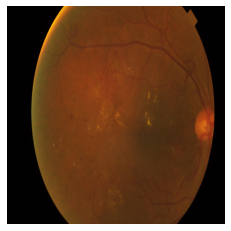

In [19]:
from PIL import Image
image_path = Image.open('./train_imgs_reshaped/000c1434d8d7.png')
plt.imshow(image_path)
plt.axis("off")

## Configure the hyperparameters

In [20]:
num_classes = 5
input_shape = (512, 512, 3)
learning_rate = 1e-4 #0.001
weight_decay = 0.0001
batch_size = 16 #256
num_epochs = 100
# We'll resize input images to this size
image_size =  256 
# Size of the patches to be extract from the input images
patch_size = 7 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
# Size of the dense layers of the final classifier
mlp_head_units = [56, 28] #[1024, 512]  

In [21]:
num_patches

1296

In [22]:
@tf.function
def load(image_file, target):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    image_ = tf.cast(image, tf.uint8)
    return image, target

In [23]:
train_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)
test_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)

In [25]:
train_batch = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(X_train.shape[0]-100)#X_train.shape[0]-100
)
#next(iter(train_batch))[0].shape

## Data Augmentation

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
CompleteBatchData  =next(iter(train_batch))[0]
data_augmentation.layers[0].adapt(CompleteBatchData)

In [31]:
del CompleteBatchData
gc.collect()

122

## Implementing multilayer perceptron (MLP)

In [32]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [33]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        #print(patches.shape)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


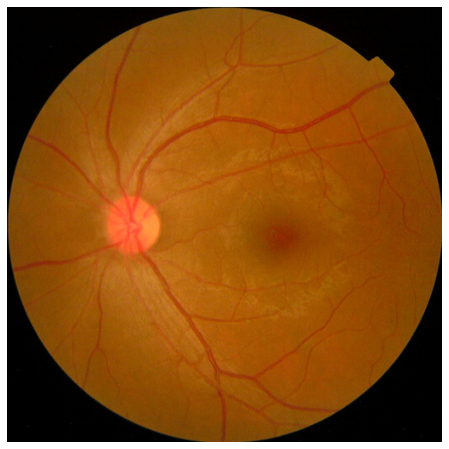

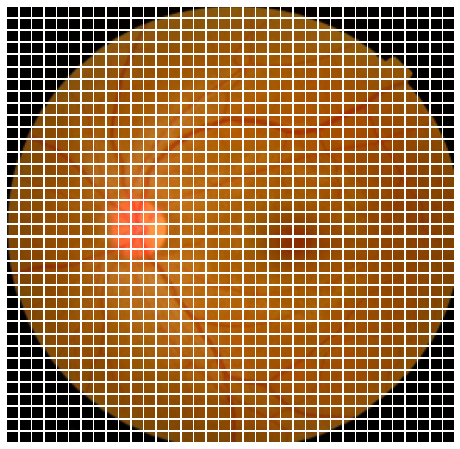

In [34]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
#print(n)

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


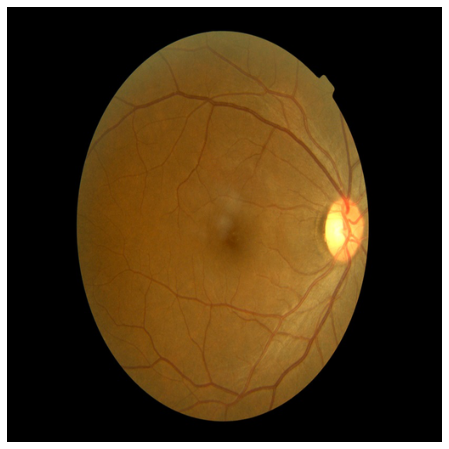

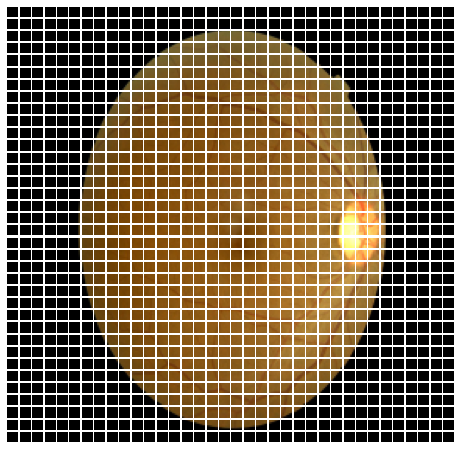

In [35]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
#print(n)

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

## The patch encoding layer

The **PatchEncoder** layer will linearly transform a **patch** by projecting it into a vector of size **projection_dim**. In addition, it adds a learnable position embedding to the projected vector.

In [36]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

##  The ViT model

The ViT model consists of multiple Transformer blocks, which use the **layers.MultiHeadAttention layer** as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a **[batch_size, num_patches, projection_dim]** tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.<br>
Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929), which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with **layers.Flatten()** and used as the image representation input to the classifier head. Note that the **layers.GlobalAveragePooling1D** layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [37]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.BatchNormalization()(encoded_patches)
        # create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.BatchNormalization()(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax')(features)
    # create keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [32]:
def experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_loader ,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=test_loader,
                        callbacks=[checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history

In [38]:
vit_classifier = vit_model()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 256, 256, 3)  7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 147)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 1296, 64)     92416       patches_2[0][0]                  
______________________________________________________________________________________________

In [ ]:
history = experiment(vit_classifier)

Epoch 1/100
154/154 [==============================] - 174s 1s/step - loss: 2.0924 - accuracy: 0.3991 - AUC: 0.6972 - val_loss: 1.2024 - val_accuracy: 0.5856 - val_AUC: 0.8155
Epoch 2/100
154/154 [==============================] - 154s 1000ms/step - loss: 1.3430 - accuracy: 0.4945 - AUC: 0.7755 - val_loss: 1.0907 - val_accuracy: 0.6038 - val_AUC: 0.8456
Epoch 3/100
154/154 [==============================] - 155s 1s/step - loss: 1.2604 - accuracy: 0.5217 - AUC: 0.7951 - val_loss: 1.0571 - val_accuracy: 0.6600 - val_AUC: 0.8548
Epoch 4/100
154/154 [==============================] - 155s 1s/step - loss: 1.2662 - accuracy: 0.5575 - AUC: 0.8096 - val_loss: 1.0466 - val_accuracy: 0.6667 - val_AUC: 0.8728
Epoch 5/100
154/154 [==============================] - 155s 1s/step - loss: 1.2701 - accuracy: 0.5364 - AUC: 0.8102 - val_loss: 1.0174 - val_accuracy: 0.6600 - val_AUC: 0.8725
Epoch 6/100
154/154 [==============================] - 155s 1s/step - loss: 1.1812 - accuracy: 0.5853 - AUC: 0.8281 

## Load the model

In [39]:
vit_classifier.load_weights("../input/callback/checkpoint")

In [40]:
!mkdir -p saved_model
vit_classifier.save('saved_model/my_model')

## Download the saved model

In [47]:
import shutil
folder_path = "./saved_model/my_model"
shutil.make_archive(folder_path, 'zip', folder_path)

'/kaggle/working/saved_model/my_model.zip'

In [48]:
from IPython.display import FileLink

zip_file_path = folder_path + '.zip'

FileLink(zip_file_path)

/kaggle/working/saved_model/my_model.zip

## Model Performance Visulization

In [49]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [56]:
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 864x720 with 0 Axes>

In [ ]:
def get_img_array(img):
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## The Grad-CAM algorithm

In [ ]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## superimposed visualization

In [ ]:
classes.values()

In [ ]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4, preds=[0,0,0,0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.set(title =
        " No DR: \
        {:.3f}\nMild: \
        {:.3f}\nModerate: \
        {:.3f}\nSevere: \
        {:.3f}\nProliferative: \
        {:.3f}".format(preds[0], \
                    preds[1], \
                    preds[2], \
                    preds[3],
                    preds[4])
    )
    plot.axis('off')

## Implement Grad CAM

In [ ]:
# As in layer_normalization (LayerNorma (None, 1296, 64) ) 
#the last dim is 1296 so 36x36 for heatmap
np.sqrt(1296)

In [ ]:
test_image = next(iter(test_loader))[0][5]
# Prepare image
img_array =get_img_array(test_image)

last_conv_layer_name = 'layer_normalization'
# Remove last layer's softmax
vit_classifier.layers[-1].activation = None
# Print what the top predicted class is
preds = vit_classifier.predict(img_array)
print("Predicted:\n" + "No DR: \
    {p1}\nMild: {p2}\nModerate: \
    {p3}\nSevere: \
    {p4}\nProliferative: {p5}".format(p1=preds[0][0], \
                                            p2=preds[0][1],p3=preds[0][2],p4=preds[0][3],p5=preds[0][4]))
# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (36,36))
# Display heatmap
plt.matshow(heatmap)

plt.show()

## Heat-Map Visualization over Test-set

In [ ]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(test_loader))[0][:6], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    vit_classifier.layers[-1].activation = None
    # Print what the top predicted class is
    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (36,36))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)

In [ ]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(test_loader))[0][6:12], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    vit_classifier.layers[-1].activation = None
    # Print what the top predicted class is
    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

    heatmap = np.reshape(heatmap, (36,36))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)